<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Data_analysis4_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the fourth dataset 

In [1]:
#@title
import zipfile
import io
import cv2
import glob 
import numpy as np
import random 
import torch 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import drive

torch.manual_seed(0) # Reproducible, for now 

FIGSIZE = (12,10)

!rm -rf main_dir
!rm -rf data.zip

drive.mount('/content/drive/')
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data4/random.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

import sys
sys.path.append('local_modules')

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/utils.py -P local_modules -nc
import local_modules.utils as utils

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
--2020-03-11 16:04:28--  https://raw.githubusercontent.com/lustea0201/Interpretability/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6513 (6.4K) [text/plain]
Saving to: ‘local_modules/utils.py’

utils.py            100

In [0]:
transf_temp =  transforms.Compose( [ToTensor()])
train_data_temp = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf_temp)
dataloader_temp = DataLoader(train_data_temp, batch_size = 64, shuffle = True, num_workers = 0)
MEAN, STD = utils.datasetMeanStd(dataloader_temp)

transf = transforms.Compose( [ToTensor(), Normalize(mean=MEAN, std=STD)])
train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
val_data = ImageFolder(root = os.path.join(root_dir, 'val'), transform = transf)
test_data = ImageFolder(root = os.path.join(root_dir, 'test'), transform = transf)

# Dataset description 


*   Label 0: the image doesn't contain any shape 
*   Label 1: the image contains at least one shape 
Here are two examples: 



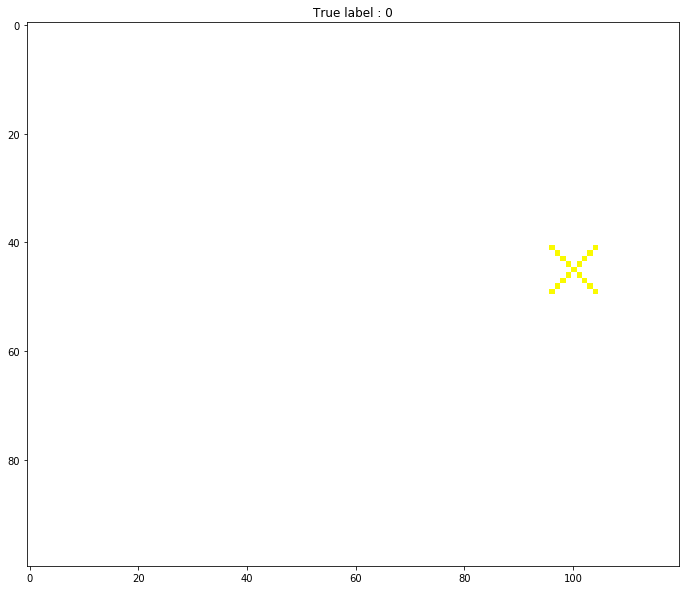

In [4]:
#@title
img0 = utils.input2image(train_data[0][0], MEAN, STD)
utils.display_image(img0, train_data[0][1])

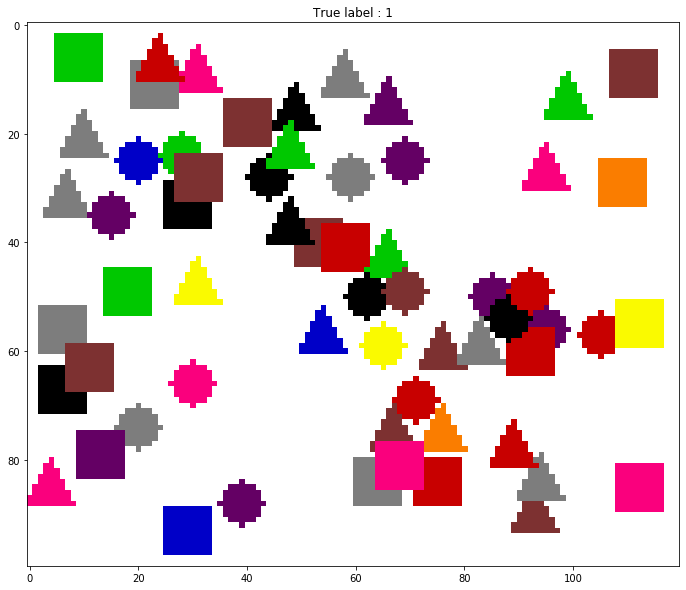

In [5]:
img1 = utils.input2image(train_data[-1][0], MEAN, STD)
utils.display_image(img1, train_data[-1][1])

In [0]:
#@title
batch_Size = 64
dataloader = DataLoader(train_data, batch_size = batch_Size, shuffle = True, num_workers = 0)
valloader = DataLoader(val_data, batch_size = batch_Size, shuffle = True, num_workers = 0)
testloader = DataLoader(test_data, batch_size = batch_Size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
x,y = next(train_loader)

# Model description
The neural network used to classify the images receives batches of 3x100x120 images. 
It consists of 
* two convolutional layers followed by max pooling 
* three fully connected layers

In [0]:
net = utils.Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters()) 

In [8]:
max_epochs = 50
train_loss, val_loss, train_accuracy, val_accuracy = utils.train(net, optimizer, criterion, max_epochs, dataloader, valloader)

Generation 1. training loss: 0.0086, training accuracy: 90.23 %, validation loss: 0.0045,  validation accuracy: 89.60 % 
Generation 2. training loss: 0.0024, training accuracy: 96.83 %, validation loss: 0.0017,  validation accuracy: 96.40 % 
Generation 3. training loss: 0.0013, training accuracy: 96.19 %, validation loss: 0.0021,  validation accuracy: 95.75 % 
Generation 4. training loss: 0.0007, training accuracy: 99.27 %, validation loss: 0.0008,  validation accuracy: 98.55 % 
Generation 5. training loss: 0.0006, training accuracy: 99.57 %, validation loss: 0.0008,  validation accuracy: 98.25 % 
Generation 6. training loss: 0.0004, training accuracy: 99.64 %, validation loss: 0.0007,  validation accuracy: 98.70 % 
Generation 7. training loss: 0.0003, training accuracy: 99.72 %, validation loss: 0.0007,  validation accuracy: 98.65 % 
Generation 8. training loss: 0.0004, training accuracy: 99.81 %, validation loss: 0.0007,  validation accuracy: 98.70 % 
Generation 9. training loss: 0.0

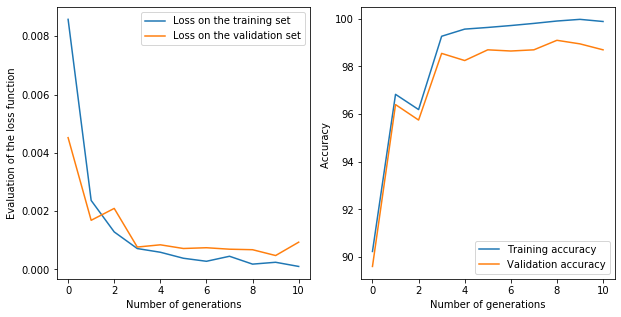

In [9]:
utils.plot_training(train_loss, val_loss, train_accuracy, val_accuracy)

In [10]:
wi, wl, wpl = utils.test(net, testloader)
index = 0

Accuracy of the network on the 4000 test images: 99.150 %
Number of mistakes : 34


Score for predicted label:  2.3946087
Score for true label:  -3.147977


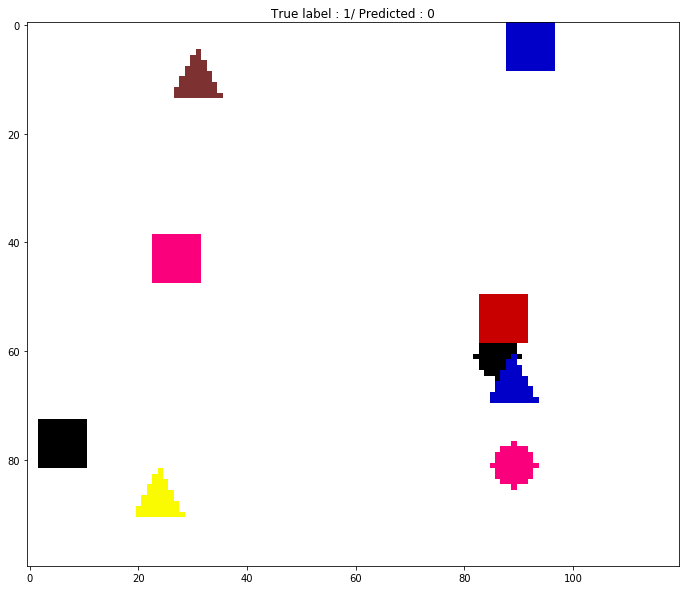

In [11]:
if index in range(len(wi)):
  I = utils.input2image(wi[index], MEAN, STD)
  utils.display_image(I, wl[index], wpl[index])
  outputs = net(wi[index].unsqueeze(0)).data
  print("Score for predicted label: ", outputs.numpy()[0][wpl[index]])
  print("Score for true label: ", outputs.numpy()[0][wl[index]])
  index += 1

In [0]:
index = 0

In [13]:
save = input("Overwrite current state dictionnary ? [y/n]")
if (save == 'y'): 
  torch.save(net.state_dict(), 'drive/My Drive/Interpretability/model4_random.pth')
  print("State dictionnary saved.")
else: 
  print("State dictionnary has not been saved.")

Overwrite current state dictionnary ? [y/n]y
State dictionnary saved.
